<a href="https://colab.research.google.com/github/tacianoamorim/arima/blob/main/ProjetoSerieTemporal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PROJETO DISCIPLINA SÉRIES TEMPORAIS

Para rodar execute as seguintes operações:

1.   Clique no menu principal "Ambiente de execução > Executar tudo" ou rode cada célula individualmente.
2.   Preencha os campos solicitados e tecle "Enter"



## Carregado funções

In [ ]:
!pip install yahooquery

In [ ]:
#importando as bibliotecas
import numpy as np
from numpy.ma.core import append
import pandas as pd
import math

from yahooquery import Ticker
from flask import Flask, jsonify
import yahooquery as yq
from datetime import datetime, timedelta

import plotly.graph_objects as go
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt

import warnings
import json
import types
warnings.filterwarnings("ignore")

import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf, kpss
from sklearn import linear_model

from google.colab import files

In [ ]:
#
# Recupera os dados de uma acao
#
def history(ticker, dateStart, dateEnd, interval):
    tk = Ticker(ticker+".sa")
    return tk.history(start= dateStart, end= dateEnd, interval= interval)

In [ ]:
#
# Converte um dataframe em matriz com todos os elementos recuperados
#
def convertToMatrizCompleto(df):
  vetor= []
  for i in range(len(df)):
    vetor.append([df.iloc[i].name[1].strftime("%Y-%m-%d, %H:%M:%S"), df.iloc[i, df.columns.get_loc('close')], df.iloc[i, df.columns.get_loc('high')], df.iloc[i, df.columns.get_loc('low')], df.iloc[i, df.columns.get_loc('open')], df.iloc[i, df.columns.get_loc('volume')]])
  return vetor

In [ ]:
#
# Converte um dataframe em um vetor de precos
#
def _convertToVetorPreco(df):
  vetor= []
  for i in range(len(df)):
    vetor.append(df.iloc[i, df.columns.get_loc('close')])
  return vetor

In [ ]:
#
# Converte uma matriz em um dataframe
#
def convertToDF(matriz):
  column_names = ["date", "close","high", "low", "open", "volume"]
  data_df = pd.DataFrame(matriz, columns=column_names)
  return data_df

In [ ]:
#
# Realiza o tratamento no dataframe
#
def trataDf(df):
  ma= convertToMatrizCompleto(df)

  idx = (len(df)-11)
  while idx > (len(df)-11):
    ma.pop(idx)
    idx = idx - 1  

  # Converter para Matrix
  df= convertToDF(ma)
  
  return df

In [ ]:
#
# Plota gráfico
#
def _plotarGrafico(df_fec, title):
  #Plotar informacao
  plt.figure(figsize=(6,3))
  plt.title(title)
  plt.plot(df_fec['close'])
  plt.xlabel('data') 
  return "" 

In [ ]:
#
# Realiza o tratamento no dataframe
#
def _tratarDados(df):
  df= trataDf(df)

  #Seleciona os campos 
  df_fec = df[ ['date', 'close'] ] 

  # Ajustar o indices
  dfIdx = df_fec.copy()
  dfIdx = dfIdx.set_index(pd.DatetimeIndex(dfIdx['date'].values))

  # Retirar a coluna
  dfIdx.drop('date', axis=1, inplace=True)
  df.drop('date', axis=1, inplace=True)
  
  return df_fec, dfIdx

In [ ]:
#
# Realiza o KPSS test
#
def _kpss_test(series, **kw):    
  statistic, p_value, n_lags, critical_values = kpss(series, **kw)
  return p_value

In [ ]:
#
# Realiza o Portmanteau Test
#
def _calcPortmanteau(df):
  # Qtde elementos
  n= len(df)

  # Calcula o erro padrao
  erroPadrao= 1 / math.sqrt(n)

  # Calcula o de rk(â)
  arrayRK= []
  for i in n:
    arrayRK= arrayRK+i

  # Utiliza as primeiras autocorrelacoes
  k= 25

  # Calcula o valor de Q
  Q = n(n+2)* (n-k)**-1
  return 0

In [ ]:
def _estimativaAutocorrelacao(x):
    """
    http://stackoverflow.com/q/14297012/190597
    http://en.wikipedia.org/wiki/Autocorrelation#Estimation
    """
    n = len(x)
    variance = x.var()
    x = x-x.mean()
    r = np.correlate(x, x, mode = 'full')[-n:]
    assert np.allclose(r, np.array([(x[:n-k]*x[-(n-k):]).sum() for k in range(n)]))
    result = r/(variance*(np.arange(n, 0, -1)))

    return result

In [ ]:
#
# Calcula a autocovariancia de acordo com a ordem
#
def _getAutoCovariancia(xVetor, desvio, ordem):
  produto= np.array([])

  # calculo da autocovariancia
  autocovariancia= 0
  for i in range(len(desvio)):
    if i < ordem:
      produto= np.append(produto, 0)
    else:
      produto= np.append(produto, desvio[i] * desvio[i-ordem])

  autocovariancia= produto.sum() / qtdeElementos
  return autocovariancia

In [ ]:
#
# Calcula a autocorrelacao
#
def _getAutoCorrelacao(autocovariancia0, autocovariancia1):
  autocorrelacao= autocovariancia1 / autocovariancia0
  return autocorrelacao

In [ ]:

#
# Calcula a PACF
#
def _PACF(df, qtdeLag):
  dfT= df.head()

  # Cria as colunas para armazenar os valores correspondentes
  dfT['T0'] = dfT['close']
  for i in range(qtdeLag):
    dfT['T'+ str(i+1)] = dfT['close'].shift(i)

  # Remove os NA's
  dfT = dfT.dropna()
  
  # calculando a previsao
  idx= 0
  dfx= 0.0
  dfy= 0.0
  for i in range(qtdeLag):
    dfx= 0.0
    dfy= 0.0
    lml = linear_model.LinearRegression()
    dfx = dfT[['T'+str(i+1)]] 
    dfy = dfT[['T'+str(i)]] 
    model = lml.fit(dfx,dfy)
    dfT['Predicted_T'+str(i)+'_T'+ str(i+1)] = lml.predict(dfx)
    dfT['Residual_T'+str(i)+'_T'+str(i+1)] = dfT['T'+str(i)] - dfT['Predicted_T'+str(i)+'_T'+str(i+1)]
  
  #print(pacf(dfT['T0'], nlags=qtdeLag)[2])
  ##print(dfT.corr(method='pearson')[1])
  #print(dfT.corr(method='pearson')['Residual_T0_T1']['Residual_T1_T2'])
  #Residual_Ti-0_Ti-1	Predicted_Ti-1_Ti-2	Residual_Ti-1_Ti-2	Predicted_Ti-2_Ti-3	Residual_Ti-2_Ti-3
  #print(pacf(dfT['T0'], nlags=2)[2])
  return dfT

#df = pd.DataFrame(history("PETR4","2020-12-01","2021-12-01","1d"))
#df, dfIdx= _tratarDados(df)  
#dft = _PACF(df, 5)
#dft

## MAIN

----------------- Identificação da série utilizada --------------------
                close
2020-12-01  25.600000
2020-12-02  25.910000
2020-12-03  26.639999
2020-12-04  27.530001
2020-12-07  27.000000


''

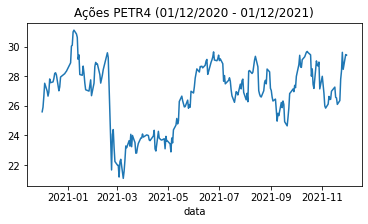

In [ ]:
print("----------------- Identificação da série utilizada --------------------")
df = pd.DataFrame(history("PETR4","2020-12-01","2021-12-01","1d"))
df, dfIdx= _tratarDados(df)
print(dfIdx.head())

# uploaded = files.upload()
# for fn in uploaded.keys():
#   print('User uploaded file "{name}" with length {length} bytes'.format(
#      name=fn, length=len(uploaded[fn])))
# print(uploaded)
# dfEE = pd.read_csv("/content/dataset.txt")
# print(dfEE.head())
_plotarGrafico(dfIdx, "Ações PETR4 (01/12/2020 - 01/12/2021)")


Calcula a média e o desvio padrão

In [ ]:
# Converte o df em array para facilitar os cálculos
vClose= _convertToVetorPreco(df)

qtdeElementos= len(vClose)

# calcular a soma 
somaClose= 0.0
for i in range(len(vClose)):
  somaClose= somaClose + vClose[i]

# Calcula a média
media= somaClose / qtdeElementos

# calcular desvio
desvio= np.array([])
for i in range(len(vClose)):
  desvio= np.append(desvio, vClose[i] - media)

quadradoDesvio= 0
for i in range(len(desvio)):
  quadradoDesvio= quadradoDesvio + desvio[i] ** 2

In [ ]:
warnings.filterwarnings("ignore")
print("----------- Informar a quantidade de diferenças desejadas -------------")
qtde = int(input("Quantidade desejada: "))  

----------- Informar a quantidade de diferenças desejadas -------------
Quantidade desejada: 1


In [ ]:
print("###########################################")
print("Qtde elementos= "+str(qtdeElementos))
print("Média= "+str(media))
print("###########################################")

# Calcula e exibe a autocovariancia 
autoCov= []
for i in range(qtde):
  c= _getAutoCovariancia(vClose, desvio, i)
  autoCov.append(c)
  print("Autocovariancia"+str(i)+" (c"+str(i)+")= "+str(c))

print("###########################################")  
print(autoCov)
# Calcula e exibe a autocorrelacao

autoCorrelacao= 0.0
for i in range(qtde):
  if ( (i+1) < qtde):
    r= _getAutoCorrelacao(autoCov[i], autoCov[i+1])
    print("Autocorrelacao"+str(i)+" (r"+str(i)+")= "+str(r))
    autoCorrelacao= r

print("###########################################")  

###########################################
Qtde elementos= 246
Média= 26.73337404514716
###########################################
Autocovariancia0 (c0)= 4.696742769541136
###########################################
[4.696742769541136]
###########################################


In [ ]:
dft = _PACF(df, qtde)
dft.head(10)

,date,close,T0,T1,Predicted_T0_T1,Residual_T0_T1
0,"2020-12-01, 00:00:00",25.600000,25.600000,25.600000,25.600000,0.000000e+00
1,"2020-12-02, 00:00:00",25.910000,25.910000,25.910000,25.910000,0.000000e+00
2,"2020-12-03, 00:00:00",26.639999,26.639999,26.639999,26.639999,0.000000e+00
3,"2020-12-04, 00:00:00",27.530001,27.530001,27.530001,27.530001,3.552714e-15
4,"2020-12-07, 00:00:00",27.000000,27.000000,27.000000,27.000000,3.552714e-15


Com a Função de Autocorrelação Parcial (PACF) descobriremos o número necessário de termos AR inspecionando. E utilizaremos a autocorrelacao para identificar o número necessário de termos MA

In [ ]:
# Calcula a acf e pacf
lag_pacf = pacf(df.close, nlags=20, method='ols')
numeroTermoAR = math.ceil(lag_pacf.sum())

numeroTermoAR = math.ceil(lag_pacf.sum())
numeroTermoMA = math.ceil(autoCorrelacao)

print("----------- Verifica se a série é estacionária (KPSS test) -------------")
print(" Número necessários de termos AR: %i" % numeroTermoAR )
print(" Número necessários de termos MA: %i" % numeroTermoMA )

----------- Verifica se a série é estacionária (KPSS test) -------------
 Número necessários de termos AR: 2
 Número necessários de termos MA: 0


In [ ]:
warnings.filterwarnings("ignore")
print("----------- Verifica se a série é estacionária (KPSS test)-------------")
p_value= _kpss_test(df.close)
if p_value < 0.06:
  print("A série não é estacionária")

else:
  print("A série é estacionária (as características estatísticas média, variância e autocorrelação são constantes ao longo do tempo")
  print(" ")
  print("---------------------- Identificação do Modelo ----------------------")
  print(" Indicação AR: %i" % numeroTermoAR )
  print(" Indicação MA: %i" % numeroTermoMA )
  print("Informe os seguintes parâmentros: ")
  p = int(input("Ordem do termo AR (p): "))  
  q = int(input("Ordem do termo MA (q): "))  
  d = int(input("N de diferenciação necessária para tornar a série temporal estacionária (d): "))  


----------- Verifica se a série é estacionária (KPSS test)-------------
A série é estacionária (as características estatísticas média, variância e autocorrelação são constantes ao longo do tempo
 
---------------------- Identificação do Modelo ----------------------
 Indicação AR: 2
 Indicação MA: 0
Informe os seguintes parâmentros: 
Ordem do termo AR (p): 2
Ordem do termo MA (q): 1
N de diferenciação necessária para tornar a série temporal estacionária (d): 1


In [ ]:
#model = sm.tsa.ARIMA(df.close, order=(p,d,q))
model = sm.tsa.ARIMA(df.close, order=(2,1,1))
model_fit = model.fit()
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.close   No. Observations:                  245
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -272.343
Method:                       css-mle   S.D. of innovations              0.735
Date:                Thu, 16 Dec 2021   AIC                            554.686
Time:                        01:51:02   BIC                            572.193
Sample:                             1   HQIC                           561.736
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0146      0.040      0.370      0.711      -0.063       0.092
ar.L1.D.close     0.4011      0.530      0.756      0.450      -0.638       1.440
ar.L2.D.close    -0.0475      0.079     

# CHECAGEM